In this notebook we will go over how to use ART to perform evasion attacks on a Hugging Face image classifier. We will be fine-tuning a pre-trained Data-efficient Image Transformer (DeiT) model available from Hugging Face on the CIFAR-10 dataset. We will apply the Projected Gradient Descent (PGD) attack on this model using ART functionality. Then we will be performing adversarial training to defend against such evasion attacks.

Afterwards, we will be demonstrating further functionality with Hugging Face models such as using the PyTorch Image Models (timm) library or a custom Hugging Face model using a created config.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision transformers timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [4]:
!pip install adversarial-robustness-toolbox tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00


In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers

from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.defences.trainer import AdversarialTrainerMadryPGD
from art.utils import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# We will use a small subset of the CIFAR-10 dataset

(x_train, y_train), (_, _), _, _ = load_dataset('cifar10')
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
y_train = np.argmax(y_train, axis=1)

classes = np.unique(y_train)
samples_per_class = 100

x_subset = []
y_subset = []

for c in classes:
    indices = y_train == c
    x_subset.append(x_train[indices][:samples_per_class])
    y_subset.append(y_train[indices][:samples_per_class])

x_subset = np.concatenate(x_subset)
y_subset = np.concatenate(y_subset)

print(f'x_subset:', x_subset.dtype, x_subset.shape)
print(f'y_subset:', y_subset.dtype, y_subset.shape)

x_subset: float32 (1000, 3, 32, 32)
y_subset: int64 (1000,)


In [7]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [8]:
# Create state_dicts directory for saving models

if not os.path.isdir('/content/drive/MyDrive/AI SECURITY/AI Red Teaming/CODE/Model/state_dicts'):
    os.mkdir('/content/drive/MyDrive/AI SECURITY/AI Red Teaming/CODE/Model/state_dicts')

## Regular Training with ART:

We will first see how to load a model into ART's HuggingFaceClassifierPyTorch, train it, and attack it with PGD.

In [9]:
# The HuggingFaceClassifierPyTorch follows broadly the same API as the PyTorchClassifier
# So we can supply the loss function, the input shape of the data we will supply, the optimizer, etc.
# Note, frequently we will be performing fine-tuning or transfer learning with vision transformers and
# so we may be fine-tuning on differently sized inputs.
# The input_shape argument refers to the shape of the supplied input data which may be different to
# the shape required by the model.
# To handle this HuggingFaceClassifierPyTorch has an extra argument of processor which will act on
# every batch to process the data into the correct form required by the supplied model.
# This needs to be manually specified by the user. For many attacks and defences to work it needs to be a
# differentiable function.
# Here the processor is a simple upsampler to enlarge the cifar images into the right size.

model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0, 1),
    processor=upsampler
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = '/content/drive/MyDrive/AI SECURITY/AI Red Teaming/CODE/Model/state_dicts/deit_cifar_base_model.pt'
if os.path.isfile(model_checkpoint_path):
    hf_model.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    hf_model.fit(x_subset, y_subset, nb_epochs=5)
    torch.save(hf_model.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

saved model checkpoint


In [11]:
outputs = hf_model.predict(x_subset)
clean_preds = np.argmax(outputs, axis=1)
clean_acc = np.mean(clean_preds == y_subset)
print('clean accuracy:', clean_acc)

clean accuracy: 0.968


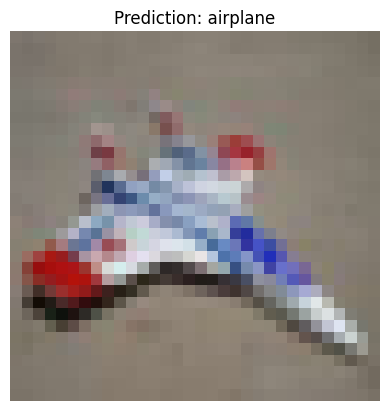

In [12]:
plt.imshow(np.transpose(x_subset[1], (1, 2, 0)))
plt.title(f'Prediction: {label_names[clean_preds[1]]}')
plt.axis('off')
plt.show()

In [13]:
# load adversarial samples if they already exist, otherwise generate them

adv_samples_path = '/content/drive/MyDrive/AI SECURITY/AI Red Teaming/CODE/Model/state_dicts/x_adv_base.npy'
if os.path.isfile(adv_samples_path):
    x_adv = np.load(adv_samples_path)
else:
    attacker = ProjectedGradientDescentPyTorch(hf_model, eps=8/255, eps_step=1/255)
    x_adv = attacker.generate(x_subset)
    np.save(adv_samples_path, x_adv)

outputs = hf_model.predict(x_adv)
adv_preds = np.argmax(outputs, axis=1)
adv_acc = np.mean(adv_preds == y_subset)
print('adversarial accuracy:', adv_acc)

PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

adversarial accuracy: 0.005


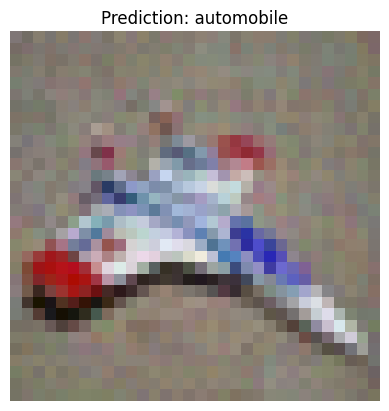

In [14]:
plt.imshow(np.transpose(x_adv[1], (1, 2, 0)))
plt.title(f'Prediction: {label_names[adv_preds[1]]}')
plt.axis('off')
plt.show()

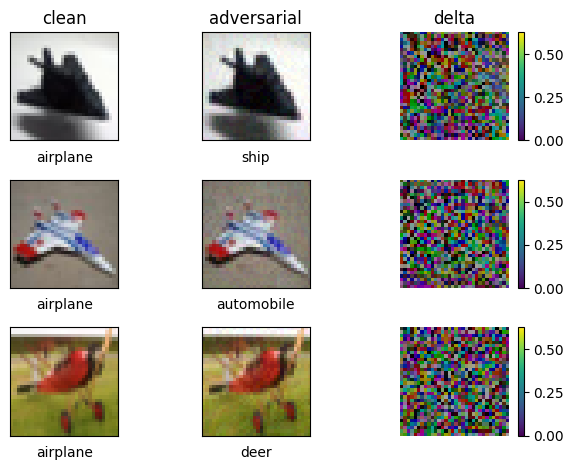

In [15]:
# We can display the adversarial examples to highlight the added perturbation to the original sample.

# shift to have min 0 and make perturbations 10x larger to visualize them.
delta = ((x_subset - x_adv) + 8/255) * 10

fig, axs = plt.subplots(3, 3)
for i in range(3):
    axs[i, 0].imshow(np.transpose(x_subset[i], (1, 2, 0)))
    axs[i, 0].set_xlabel(label_names[clean_preds[i]])
    axs[i, 0].tick_params(axis='both', which='both',length=0)
    axs[i, 0].axes.xaxis.set_ticklabels([])
    axs[i, 0].axes.yaxis.set_ticklabels([])
    axs[i, 1].imshow(np.transpose(x_adv[i], (1, 2, 0)))
    axs[i, 1].axes.xaxis.set_ticklabels([])
    axs[i, 1].axes.yaxis.set_ticklabels([])
    axs[i, 1].tick_params(axis='both', which='both',length=0)
    axs[i, 1].set_xlabel(label_names[adv_preds[i]])
    im = axs[i, 2].imshow(np.transpose(delta[i], (1, 2, 0)))
    axs[i, 2].axis('off')
    fig.colorbar(im)

axs[0, 0].set_title('clean')
axs[0, 1].set_title('adversarial')
axs[0, 2].set_title('delta')
plt.tight_layout()

## PyTorch Image Models (timm):

PyTorch Image Models (timm) is a poular repository for SOTA implementations of image models and Hugging Face is hosting many of the models and weights.

We can use timm models here with the same wrapper.

In [16]:
import timm

# We can also try different architectures,
# for example one of the most popular models on Huggingface is the resnet-50
model = timm.create_model('resnet50.a1_in1k', pretrained=True)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

timm_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    input_shape=(3, 32, 32),
    nb_classes=10,
    optimizer=optimizer,
    clip_values=(0, 1),
    processor=upsampler
)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [17]:
timm_model.fit(x_subset[:2], y_subset[:2], nb_epochs=1)

In [18]:
output = timm_model.predict(x_subset[:2])
preds = np.argmax(output, axis=1)

## Custom Hugging Face Models:

We can also create custom Hugging Face models using a custom configutation. The ART wrapper will allow us to use the model in the same way.

In [21]:
# We can also use the interface so supply custom Hugging Face models.
# Here is a simple example for running a toy neural network classifier.

from transformers.modeling_utils import PreTrainedModel
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_outputs import ImageClassifierOutput


class ModelConfig(PretrainedConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Model(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.conv = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fullyconnected = torch.nn.Linear(6272, 10)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(-1, 6272)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


config = ModelConfig()
model = Model(config=config)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
simple_hf_classifier = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0, 1),
    processor=None  # No processor is needed as the data is of the correct size for the model.
)

In [22]:
simple_hf_classifier.fit(x_subset, y_subset, nb_epochs=5)

In [23]:
outputs = simple_hf_classifier.predict(x_subset)
acc = np.mean(np.argmax(outputs, axis=1) == y_subset)
print('clean accuracy:', acc)

clean accuracy: 0.431
